# Demonstration 5: Free Choice Premium

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sisyphus.envs import FreeChoice
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

## Model-Free Temporal Difference Learning

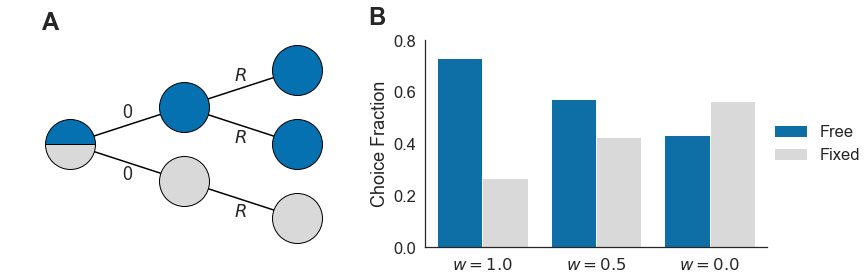

In [2]:
import os
from pandas import DataFrame, read_csv
from sisyphus.mdp import ModelFree
from sisyphus.mdp._misc import softmax
from tqdm import tqdm
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Simulation parameters.
n_agents = 500
betas = [1.0, 0.5, 0.0]
rewards = [-1,1]
overwrite = False

## Define exploration schedule.
schedule = np.logspace(0,1,100)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize environment.
gym = FreeChoice(rewards=rewards)

if not os.path.isfile('figures/05_choice.csv') or overwrite:

    data = []
    for beta in betas:

        ## Initialize agent.
        agent = ModelFree('betamax', eta=0.1, gamma=1, beta=beta)

        for _ in tqdm(range(n_agents)):

            ## Solve for Q-values.
            agent = agent.fit(gym, schedule=schedule, overwrite=True)

            ## Compute choice likelihood.
            theta = softmax(agent.Q[:2] * schedule[-1])

            ## Store results.
            data.append( dict(beta=beta, theta=theta[0], pi=agent.pi[1]) )

    ## Convert to DataFrame.
    data = DataFrame(data)

    ## Fix labels.
    data['Choice'] = np.where(data.pi==1, 'Free', 'Fixed')
    data.to_csv('figures/05_choice.csv', index=False)

else:
    
    ## Load data (if already saved).
    data = read_csv('figures/05_choice.csv')
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
## Initialize figure.
fig, axes = plt.subplots(1,2,figsize=(12,4))
palette = ['#0571B0','0.85']

## Plot environment.
gym.plot_free_choice(axes[0], free_color=palette[0], fixed_color=palette[1], edge_labels=True)
axes[0].text(-0.25,0.735,'A',ha='left',va='bottom',fontsize=24,fontweight='bold')

## Plot simulation results.
sns.countplot('beta', hue='Choice', data=data, order=betas, 
              palette=palette, saturation=0.9, ax=axes[1])

## Add details.
yticks = axes[1].get_yticks()
yticklabels = np.round(yticks / n_agents, 1)
axes[1].set(xticklabels=[r'$w=%0.1f$' %beta for beta in betas], xlabel='',
             ylabel='Choice Fraction', yticks=yticks, yticklabels=yticklabels) 
axes[1].legend(loc=7, bbox_to_anchor=(1.3,0.5), frameon=False, borderpad=0)
axes[1].text(-1,yticks.max() * 1.05,'B',ha='left',va='bottom',fontsize=24,fontweight='bold')

## Clean up.
sns.despine(ax=axes[1])
plt.tight_layout()
plt.savefig('figures/05_choice.png', dpi=180)